In [13]:
from datetime import date

import pandas as pd
import numpy as np

import yahoo_scrape as scrape
import yahoo_sql as ysql

from sklearn.covariance import ledoit_wolf
from sklearn import cluster, covariance, manifold, preprocessing
from sklearn.covariance import GraphicalLasso
from sklearn.manifold import TSNE

# Import the necessary packages
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans


from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet, Legend, HoverTool
from bokeh.palettes import all_palettes

import matplotlib.pyplot as plt

import pylab as pl

## Connecting to db

In [14]:
sql = ysql.fundamentals()
cnxn, cursor = sql.connect()

## Defining SQL-queries

In [15]:
query_fundamentals = """
WITH
	CTE_LatestDate AS
	(
		SELECT 
			MAX(F.[Date]) AS [LatestDate],
			X.Category,
			F.Ticker
		FROM
			[christopherFuru].[Yahoo].Fundamentals F
			CROSS JOIN
			(
				SELECT 'Enterprise Value/EBITDA' AS Category
				UNION
				SELECT 'Enterprise Value/Revenue'
				UNION
				SELECT 'Trailing P/E'
			) X
		GROUP BY
			X.Category,
			F.Ticker
	),

	CTE_LatestValues AS
	(
		SELECT
			LD.Ticker,
			LD.Category,
			V.Value
		FROM
			CTE_LatestDate LD
			LEFT JOIN christopherFuru.Yahoo.Fundamentals V ON
				V.[Date] = LD.LatestDate AND
				V.Ticker = LD.Ticker AND
				V.Category = LD.Category
	)

SELECT * FROM CTE_LatestValues;
"""
query_company_info = """
SELECT
    *
FROM
    [christopherFuru].[Yahoo].[Companies]
"""

## Mergin company info with fundamentals

In [16]:
df_fundamentals = pd.read_sql(query_fundamentals, cnxn)
df_fundamentals = pd.pivot_table(df_fundamentals, values = 'Value', index = 'Ticker', columns = 'Category')
df_company_info = pd.read_sql(query_company_info, cnxn)

df_fundamentals = df_fundamentals.merge(df_company_info, on = 'Ticker')
df_fundamentals

,Ticker,Enterprise Value/EBITDA,Enterprise Value/Revenue,Trailing P/E,ISIN,CompanyName,Sector,List
0,2CUREX.ST,-29.54,NaN,NaN,SE0010468124,2cureX,Health Care,First north
1,3KR.ST,11.64,11.81,7.71,SE0010169516,Tre Kronor Property Investment,Financials,First north
2,AAC.ST,-11.03,3.93,NaN,SE0009268154,ÅAC Microtec,Technology,First north
3,AAK.ST,16.86,1.69,29.06,SE0011337708,AAK,Consumer Goods,Large cap
4,AAP-B.ST,-9.68,29.56,NaN,SE0004977452,Arc Aroma Pure B,Industrials,First north
...,...,...,...,...,...,...,...,...
568,XVIVO.ST,-639.80,23.72,377.73,SE0004840718,Xvivo Perfusion,Health Care,Mid cap
569,ZAPLOX.ST,-2.26,32.82,NaN,SE0009722465,Zaplox,Technology,First north
570,ZETA.ST,4.38,0.62,15.59,SE0001105511,ZetaDisplay,Technology,Small cap
571,ZUTEC.ST,-1.42,1.87,NaN,SE0010869487,Zutec Holding,Technology,First north


## Setting color for each sector

In [17]:
category_items = df_fundamentals['Sector'].unique()
palette = all_palettes['Viridis'][len(category_items)]
colormap = dict(zip(category_items, palette))
df_fundamentals['Color'] = df_fundamentals['Sector'].map(colormap)

df_fundamentals

,Ticker,Enterprise Value/EBITDA,Enterprise Value/Revenue,Trailing P/E,ISIN,CompanyName,Sector,List,Color
0,2CUREX.ST,-29.54,NaN,NaN,SE0010468124,2cureX,Health Care,First north,#440154
1,3KR.ST,11.64,11.81,7.71,SE0010169516,Tre Kronor Property Investment,Financials,First north,#472777
2,AAC.ST,-11.03,3.93,NaN,SE0009268154,ÅAC Microtec,Technology,First north,#3E4989
3,AAK.ST,16.86,1.69,29.06,SE0011337708,AAK,Consumer Goods,Large cap,#30678D
4,AAP-B.ST,-9.68,29.56,NaN,SE0004977452,Arc Aroma Pure B,Industrials,First north,#25828E
...,...,...,...,...,...,...,...,...,...
568,XVIVO.ST,-639.80,23.72,377.73,SE0004840718,Xvivo Perfusion,Health Care,Mid cap,#440154
569,ZAPLOX.ST,-2.26,32.82,NaN,SE0009722465,Zaplox,Technology,First north,#3E4989
570,ZETA.ST,4.38,0.62,15.59,SE0001105511,ZetaDisplay,Technology,Small cap,#3E4989
571,ZUTEC.ST,-1.42,1.87,NaN,SE0010869487,Zutec Holding,Technology,First north,#3E4989


# Plottig the correlation between P/E and EV/EBITDA

In [18]:
#Setting plot output in notebook
# output_notebook()

TOOLS = "crosshair, \
        pan, \
        wheel_zoom, \
        reset, \
        tap, \
        save, \
        box_select"

source = ColumnDataSource(dict(x = df_fundamentals['Trailing P/E'],
                               y = df_fundamentals['Enterprise Value/EBITDA'],
                               color = df_fundamentals['Color'],
                               ticker = df_fundamentals['Ticker'],
                               sector = df_fundamentals['Sector']))

hover = HoverTool(tooltips=[
                            ("index", "$index"),
                            ("sector", "@sector"),
                            ("ticker", "@ticker"),
                            ("(x,y)", "($x, $y)"),
                            ]
                    )

p = figure(tools = [TOOLS, hover], plot_width = 800, plot_height = 700)

labels = LabelSet(x = 'x', 
                  y = 'y', 
                  text = 'label', 
                  source = source,
                  text_font_size='8pt')

# Remove "legend='sector'," to remove legend
p.scatter(x = 'x', 
          y = 'y', 
          color = 'color', 
          legend_label = 'sector', 
          source = source)

p.title.text = "Current Valuation Structure"
p.title.text_font_size = "25px"

# Uncomment the following line to add labels
# p.add_layout(labels)

p.xaxis.axis_label = 'Trailing P/E'
p.yaxis.axis_label = 'Enterprise Value/EBITDA'

show(p)

# Importing daily stock prices

In [19]:
query_prices = """
DECLARE 
	@DateFrom DATE = (SELECT MIN(Date) FROM [christopherFuru].[Yahoo].[prices]),
	@DateTo DATE =(SELECT MAX(Date) FROM [christopherFuru].[Yahoo].[prices]);

WITH
	CTE_Companies AS
	(
		SELECT DISTINCT
			C.Ticker,
			C.CompanyName,
			C.List,
			C.Sector
		FROM
			christopherFuru.yahoo.companies C
	),

	CTE_Prices AS
	(
		SELECT 
			P.Date,
			P.Ticker,
			C.CompanyName,
			C.List,
			C.Sector,
			P.ClosePriceInSek
		FROM
			CTE_Companies C 
			JOIN [christopherFuru].[Yahoo].[prices] P ON
				P.Ticker = C.Ticker
		WHERE
			P.Date >= @DateFrom AND 
			P.Date <= @DateTo
	)

SELECT * FROM CTE_Prices;
"""

In [20]:
df_price_company = pd.read_sql(query_prices, cnxn)
df_prices_daily = pd.pivot_table(df_price_company, values = 'ClosePriceInSek', index = 'Date',
                    columns = ['Ticker'], aggfunc = np.sum, fill_value = 1)

df_prices_daily.index = pd.to_datetime(df_prices_daily.index)
df_prices_weekly = df_prices_daily.resample('W').ffill()

# Daily price change

In [21]:
# df_price_variation = df_prices_daily.shift(1) - df_prices_daily
df_price_variation = np.log1p(df_prices_weekly.pct_change()[1:])
df_price_variation = df_price_variation[1:].T
df_price_variation

Date,2019-01-20,2019-01-27,2019-02-03,2019-02-10,2019-02-17,2019-02-24,2019-03-03,2019-03-10,2019-03-17,2019-03-24,...,2020-07-19,2020-07-26,2020-08-02,2020-08-09,2020-08-16,2020-08-23,2020-08-30,2020-09-06,2020-09-13,2020-09-20
Ticker,,,,,,,,,,,,,,,,,,,,,
2CUREX.ST,-0.030640,0.007748,-0.035916,-0.006881,-0.122257,0.056875,-0.119939,-0.051145,0.041401,0.004187,...,-3.005683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.917771,0.031918
3KR.ST,0.008811,0.017392,0.008585,0.025318,0.000000,-0.008368,0.033061,-0.033061,0.016667,-0.008299,...,-4.828314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.867534,0.011472
AAC.ST,0.026680,0.007861,-0.034542,-0.032960,0.047731,-0.044953,-0.149982,0.038124,0.057509,0.184771,...,-1.223775,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.081805,0.021795
AAK.ST,0.036061,-0.003775,-0.012483,-0.007843,0.060652,0.031185,-0.026113,-0.035613,0.003738,-0.015038,...,-0.036072,0.042118,-0.017926,0.055596,0.011845,0.024162,0.020132,-0.032289,-0.001194,-0.005091
AAP-B.ST,0.012404,-0.048945,0.064236,-0.120822,0.016979,0.021649,-0.021649,-0.025576,-0.054404,-0.101451,...,-2.663750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.583998,-2.583998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XVIVO.ST,-0.016406,-0.022815,0.010712,0.077581,0.113077,0.017457,0.080708,-0.030095,0.065933,-0.084913,...,0.015784,0.006689,0.004435,0.030503,0.080373,0.002472,0.002466,0.024332,0.030772,0.103961
ZAPLOX.ST,-0.097111,0.099679,0.000000,0.032790,-0.069347,-0.167538,-0.012658,-0.025808,0.000000,-0.019803,...,0.294371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.430783,-0.063513
ZETA.ST,-0.020087,0.045334,0.087473,-0.036180,0.015666,0.055430,-0.009852,-0.009950,-0.040822,0.055711,...,-2.740840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Clustering
https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#sphx-glr-auto-examples-applications-plot-stock-market-py

https://medium.com/datadriveninvestor/stock-market-clustering-with-k-means-clustering-in-python-4bf6bd5bd685

## Kmeans

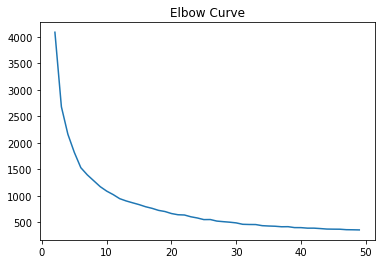

In [25]:
sse = []
for k in range(2,50):
    
    kmeans = cluster.KMeans(n_clusters = k)
    kmeans.fit(df_price_variation)
    
    sse.append(kmeans.inertia_) #SSE for each n_clusters

pl.plot(range(2,50), sse)
pl.title("Elbow Curve")
pl.show()

In [23]:
# Define a normalizer
normalizer = Normalizer()

# Create Kmeans model
kmeans = KMeans(n_clusters = 15, max_iter = 1000)

# Make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer, kmeans)

# Fit pipeline to daily stock movements
pipeline.fit(df_price_variation)
labels = pipeline.predict(df_price_variation)
names = df_price_variation.index

df_clusters = pd.DataFrame(df_price_company['CompanyName'].unique(), columns = ['CompanyName']).set_index('CompanyName')
for i in range(labels.max() + 1):
    df_clusters.loc[labels == i, 'Cluster'] = i + 1
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))
    print('-----------------------------')


Cluster 1: 2CUREX.ST, 3KR.ST, AAC.ST, AAP-B.ST, ABSO.ST, ACCON.ST, ADDERA.ST, ADVE.ST, AEC.ST, AGES-B.ST, AJA-B.ST, ALLG-B.ST, ALM-PREF.ST, ALM.ST, AMAST.ST, ARCOMA.ST, AROC.ST, AROS-PREF.ST, ASAI.ST, ASPIRE.ST, ATVEXA-B.ST, AVEN.ST, AWRD.ST, AXOLOT.ST, AZELIO.ST, BIOS.ST, BIOVIC-B.ST, BIOWKS.ST, BONES.ST, BOTX.ST, BRE2.ST, BRIG.ST, BYGGP.ST, CAG.ST, CAPAC.ST, CFISH.ST, CI-B.ST, CIBUS.ST, CLBIO.ST, CLEM.ST, CLIME-B.ST, CLS-B.ST, CONF.ST, DDM.ST, DELARK.ST, DIST.ST, DOME.ST, EFFP.ST, EOS.ST, EXPRS2.ST, FASTAT.ST, FIL.ST, FIRE.ST, FLEXM.ST, FLUI.ST, FOOT-B.ST, FRISQ.ST, GABA.ST, GAPW-B.ST, GENI.ST, GENO.ST, GHUS-B.ST, GOMX.ST, GPG-PREF.ST, GPX.ST, GREAT.ST, HANZA.ST, HEGR.ST, HEIM-PREF.ST, HELIO.ST, HEMC.ST, HIFA-B.ST, HOVD.ST, HOYLU.ST, ICO.ST, IMPC.ST, INCOAX.ST, INTEG-B.ST, IRIS.ST, IRRAS.ST, ISOFOL.ST, ISR.ST, ITECH.ST, IVACC.ST, JDT.ST, JETPAK.ST, JLT.ST, K2A-PREF.ST, KAMBI.ST, KAN.ST, KAPIAB.ST, KOPY.ST, LEX.ST, LIDDS.ST, LIVI.ST, LOUDS.ST, MAGI.ST, MANG.ST, MAXF.ST, ME.ST, MYFC.ST

In [24]:
df_kmeans = df_fundamentals.merge(df_clusters, on = 'CompanyName')
for i in range(labels.max() + 2):
    df_kmeans.loc[df_kmeans['Cluster'] == i, 'Cluster average P/E'] = np.mean(df_kmeans[df_kmeans['Cluster'] == i]['Trailing P/E'])
    df_kmeans.loc[df_kmeans['Cluster'] == i, 'Cluster average EV/EBITDA'] = np.mean(df_kmeans[df_kmeans['Cluster'] == i]['Enterprise Value/EBITDA'])
    df_kmeans.loc[df_kmeans['Cluster'] == i, 'Cluster average EV/Revenue'] = np.mean(df_kmeans[df_kmeans['Cluster'] == i]['Enterprise Value/Revenue'])

for i in df_kmeans.Sector.unique():
    df_kmeans.loc[df_kmeans['Sector'] == i, 'Sector average P/E'] = np.mean(df_kmeans[df_kmeans['Sector'] == i]['Trailing P/E'])
    df_kmeans.loc[df_kmeans['Sector'] == i, 'Sector average EV/EBITDA'] = np.mean(df_kmeans[df_kmeans['Sector'] == i]['Enterprise Value/EBITDA'])

df_kmeans['% Over/Undervaluation (P/E)'] = (df_kmeans['Trailing P/E'] / df_kmeans['Cluster average P/E'] - 1)
df_kmeans['% Over/Undervaluation (EV/EBITDA)'] = (df_kmeans['Enterprise Value/EBITDA'] / df_kmeans['Cluster average EV/EBITDA'] - 1)
df_kmeans['% Over/Undervaluation (EV/Revenue)'] = (df_kmeans['Enterprise Value/Revenue'] / df_kmeans['Cluster average EV/Revenue'] - 1)

df_kmeans['% Over/Undervaluation (P/E)'] = df_kmeans['% Over/Undervaluation (P/E)'].fillna(0)
df_kmeans['% Over/Undervaluation (EV/EBITDA)'] = df_kmeans['% Over/Undervaluation (EV/EBITDA)'].fillna(0)
df_kmeans['% Over/Undervaluation (EV/Revenue)'] = df_kmeans['% Over/Undervaluation (EV/Revenue)'].fillna(0)

df_kmeans['% Total Over/Undervaluation'] = df_kmeans['% Over/Undervaluation (EV/EBITDA)'] + df_kmeans['% Over/Undervaluation (P/E)'] + df_kmeans['% Over/Undervaluation (EV/Revenue)']
df_kmeans.sort_values(by = '% Total Over/Undervaluation')

,Ticker,Enterprise Value/EBITDA,Enterprise Value/Revenue,Trailing P/E,ISIN,CompanyName,Sector,List,Color,Cluster,Cluster average P/E,Cluster average EV/EBITDA,Cluster average EV/Revenue,Sector average P/E,Sector average EV/EBITDA,% Over/Undervaluation (P/E),% Over/Undervaluation (EV/EBITDA),% Over/Undervaluation (EV/Revenue),% Total Over/Undervaluation
524,TALK.ST,-73.36,6.77,NaN,CH0322161768,TalkPool,Telecommunications,First north,#FDE724,8.0,17.887000,1.933077,2.687143,46.412500,4.977143,0.000000,-38.949861,1.519405,-37.430456
517,SUS.ST,132.05,23.91,NaN,SE0009947948,Surgical Science Sweden,Health Care,First north,#440154,7.0,33.584167,-5.813421,130.674706,78.307500,-54.432034,0.000000,-23.714680,-0.817027,-24.531707
128,CIBUS.ST,243.15,187.00,NaN,SE0010832204,Cibus Nordic Real Estate,Financials,First north,#472777,1.0,56.536974,-10.067719,90.367000,26.980351,35.196515,0.000000,-25.151448,1.069339,-24.082109
213,FOOT-B.ST,142.38,3.06,232.66,SE0011563295,Footway Group B,Consumer Services,First north,#1E9C89,7.0,33.584167,-5.813421,130.674706,83.797813,44.065962,5.927669,-25.491603,-0.976583,-20.540517
154,DDM.ST,183.75,70.41,NaN,CH0246292343,DDM Holding,Financials,First north,#472777,1.0,56.536974,-10.067719,90.367000,26.980351,35.196515,0.000000,-19.251403,-0.220844,-19.472247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,CCC.ST,103.68,12.37,NaN,CH0136071542,Cavotec,Industrials,Mid cap,#25828E,8.0,17.887000,1.933077,2.687143,26.286905,8.858333,0.000000,52.634700,3.603402,56.238102
568,XVIVO.ST,-639.80,23.72,377.73,SE0004840718,Xvivo Perfusion,Health Care,Mid cap,#440154,1.0,56.536974,-10.067719,90.367000,78.307500,-54.432034,5.681115,62.549646,-0.737515,67.493246
328,LUG.ST,-699.00,NaN,NaN,CA5503711080,Lundin Gold,Basic Materials,Mid cap,#6BCD59,1.0,56.536974,-10.067719,90.367000,24.557500,-23.243429,0.000000,68.429826,0.000000,68.429826
269,INDEX.ST,-4.91,6560.00,NaN,SE0008966295,InDex Pharmaceuticals Holding,Health Care,First north,#440154,1.0,56.536974,-10.067719,90.367000,78.307500,-54.432034,0.000000,-0.512303,71.592871,71.080569


In [27]:
df_kmeans.to_excel(f'ClusteringResults_{date.today()}.xlsx')